In [31]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt


# We use Python's `functools.partial` to create a new function based on `fast_system` 
# with "eps" set to zero.
from functools import partial
from scipy.integrate import odeint
from sympy import symbols, Eq, solve, Function, Matrix, diff
#from scipy.integrate import solve_ivp


# Define the ODE systems
def fast_vanderpol(y, t, eps):
    x, y = y
    dxdt = y - (x**3)/3 + x
    dydt = -eps * x
    return [dxdt, dydt]


def slow_vanderpol(y, tau, eps):
    x, y = y
    dxdtau =  (y - (x**3)/3 + x)/eps
    dydtau = - x
    return [dxdtau, dydtau]



# Initial points x, y:
x_init, y_init = 0.7, 1.0
print('The initial points of the BVP:', f"x_init = {x_init}, y_init = {y_init}")
       

t_end = 10
t  =  np.linspace(0, t_end, 100)
t2  =  np.linspace(0, -t_end, 100)
eps = 0.001
T_slow_end = 5
tau = np.linspace(0, T_slow_end, 100)

x_real, y_real = odeint(fast_vanderpol, [x_init, y_init], t/eps, args=(eps,)).T
x_end, y_end = -0.1, -0.62
print('The ending points of the BVP:', f"x_end = {x_end}, y_end = {y_end}")

t_tensor = torch.tensor(t.reshape(-1, 1), dtype=torch.float64) 
tau_tensor = torch.tensor(tau.reshape(-1, 1), dtype=torch.float64)
t2_tensor = torch.tensor(t2.reshape(-1, 1), dtype=torch.float64)

x_real_tensor = torch.tensor(x_real.reshape(-1, 1), dtype=torch.float32)
y_real_tensor = torch.tensor(y_real.reshape(-1, 1), dtype=torch.float32)


def input_transform(t_tensor):
    return torch.cat([t_tensor], dim=1)

num_nrn = 5

class fast_system_PINN(nn.Module):
    def __init__(self):
        super(fast_system_PINN, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t):
        x = F.tanh(self.fc1(t))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

    
class fast_system_PINN2(nn.Module):
    def __init__(self):
        super(fast_system_PINN2, self).__init__()
        self.fc1 = nn.Linear(1, num_nrn)
        self.fc2 = nn.Linear(num_nrn, num_nrn)
        self.fc3 = nn.Linear(num_nrn, 2)

    def forward(self, t2):
        x = F.tanh(self.fc1(t2))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    
phys_weight = 1

def loss_func_fast(model, t_tensor, x_init, y_init,\
                                   x_f_end, y_f_end, eps, random_points=10):
    t_tensor.requires_grad = True
    pred_fast = model(t_tensor)
    x_pred_fast, y_pred_fast = pred_fast[:, 0].unsqueeze(1), pred_fast[:, 1].unsqueeze(1)
    #ones = torch.ones_like(x_pred_fast, requires_grad=True)    
    dx_dt = torch.autograd.grad(x_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    dy_dt = torch.autograd.grad(y_pred_fast.sum(), t_tensor, retain_graph=True, create_graph=True)[0]
    
    #for the fast system
    residual1_fast =  dx_dt -  (y_pred_fast - (x_pred_fast**3)/3 + x_pred_fast)
    residual2_fast =  dy_dt + eps * x_pred_fast
    #for the fast subsystem
    residual3_fast =  dy_dt 
    init_loss_fast = torch.square(x_pred_fast[0] - x_init) +\
                     torch.square(y_pred_fast[0] - y_init)                 
    physics_loss_fast = torch.mean(residual1_fast**2 + residual2_fast**2 +\
                                   residual3_fast**2)
    boundary_loss_fast = torch.square(x_pred_fast[-1] - x_f_end) +\
                         torch.square(y_pred_fast[-1] - y_f_end) 
    
    total_loss_fast   = phys_weight * physics_loss_fast +\
                        init_loss_fast + boundary_loss_fast
    return total_loss_fast
def loss_func_fast2(model, t2_tensor, x_end, y_end,\
                                 x_f2_end, y_f2_end, eps, random_points=10):
    t2_tensor.requires_grad = True
    pred_fast2 = model(t2_tensor)
    x_pred_fast2, y_pred_fast2 = pred_fast2[:, 0].unsqueeze(1), pred_fast2[:, 1].unsqueeze(1)
                                            
    ones = torch.ones_like(x_pred_fast2, requires_grad=True)  
    dx_dt2 = torch.autograd.grad(x_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    dy_dt2 = torch.autograd.grad(y_pred_fast2, t2_tensor, grad_outputs=ones, retain_graph=True, create_graph=True)[0]
    # for the fast system
    residual1_fast2 =  dx_dt2 -  (y_pred_fast2 - (x_pred_fast2**3)/3 + x_pred_fast2)
    residual2_fast2 = dy_dt2 + eps * x_pred_fast2
    # for the fast subsystem
    residual3_fast2 =  dy_dt2
    
    init_loss_fast2 = torch.square(x_pred_fast2[0] - x_end) +\
                      torch.square(y_pred_fast2[0] - y_end) 
    physics_loss_fast2 = torch.mean(residual1_fast2**2 + residual2_fast2**2 +\
                                    residual3_fast2**2)
    boundary_loss_fast2 = torch.square(x_pred_fast2[-1] - x_f2_end) +\
                          torch.square(y_pred_fast2[-1] - y_f2_end) 
 
    total_loss_fast2 = phys_weight * physics_loss_fast2 +\
                       init_loss_fast2 + boundary_loss_fast2        

    return total_loss_fast2


def total_loss_func(model_fast, model_fast2, t_tensor, t2_tensor,\
                    x_init, y_init, x_f_end, y_f_end,\
                    x_end, y_end, x_f2_end, y_f2_end, eps,\
                    weight_fast=1.0):
    loss_fast = loss_func_fast(model_fast, t_tensor, x_init, y_init,\
                                                   x_f_end, y_f_end, eps)
    loss_fast2 = loss_func_fast2(model_fast2, t2_tensor, x_end, y_end,\
                                                   x_f2_end, y_f2_end, eps)

    total_loss = weight_fast * loss_fast + weight_fast * loss_fast2
    
    return total_loss


The initial points of the BVP: x_init = 0.7, y_init = 1.0
The ending points of the BVP: x_end = -0.1, y_end = -0.62


Epoch 0, Total Loss: 17.058293266829494
Epoch 1000, Total Loss: 0.3216704074486676
Epoch 2000, Total Loss: 0.3041673321505208
Epoch 3000, Total Loss: 0.04304880402137336
Epoch 4000, Total Loss: 0.04246240111153181


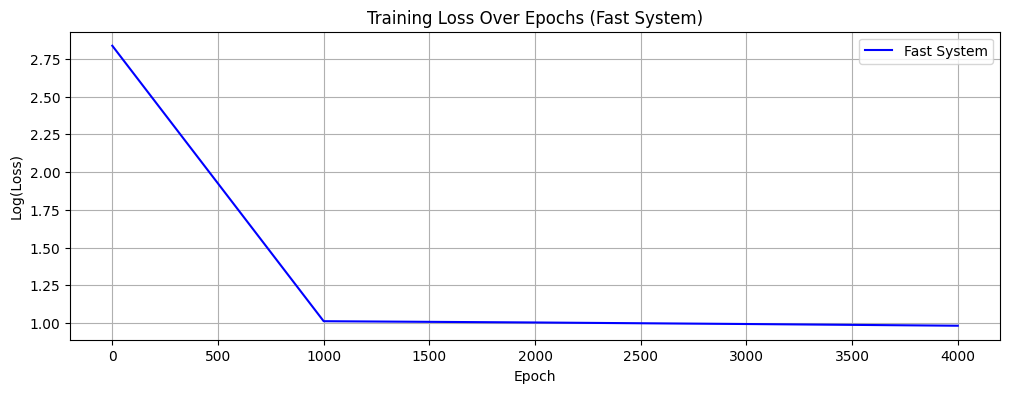

/tmp/ipykernel_253/1325376545.py:56: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "go" (-> color='g'). The keyword argument will take precedence.
  plt.plot(x_init, y_init, 'go', color='cyan', label='Initial point')


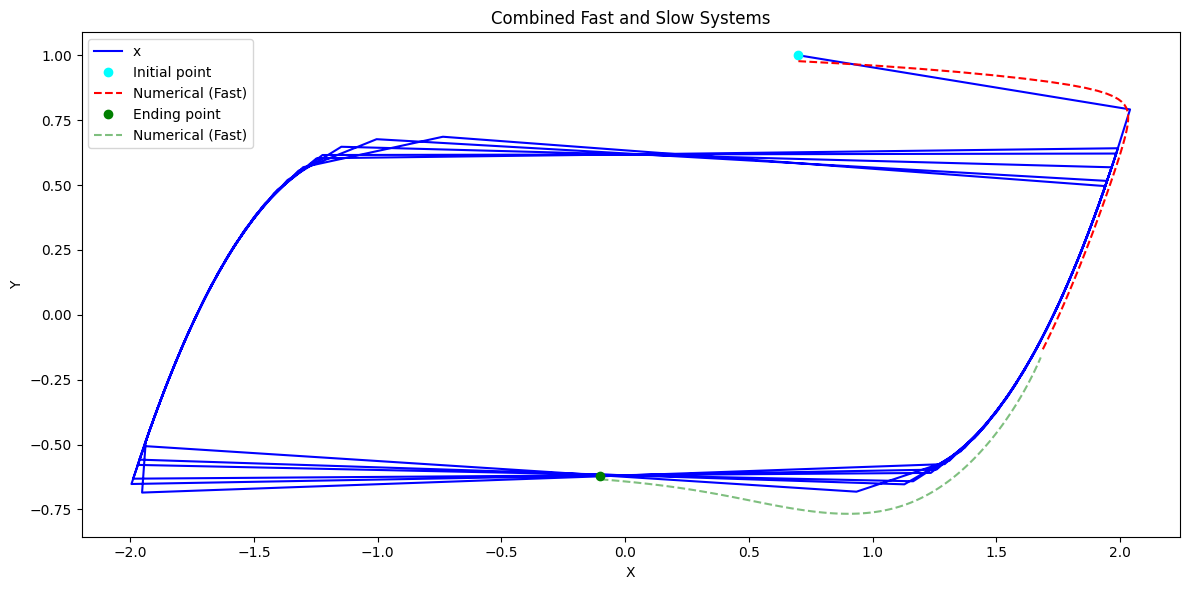

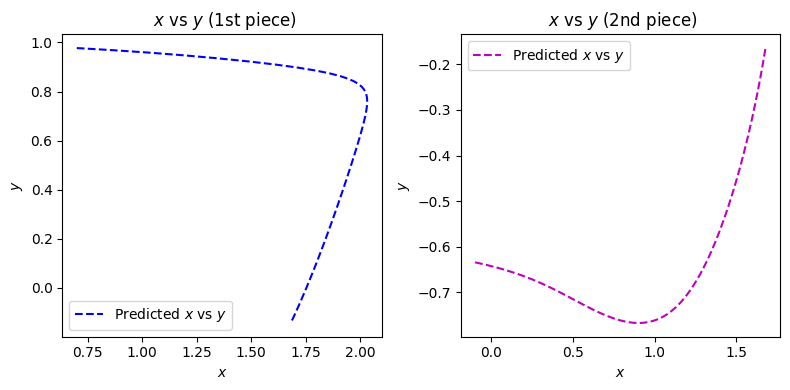

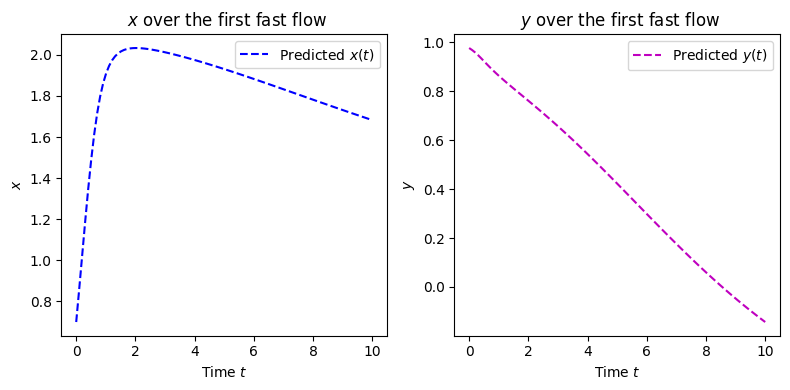

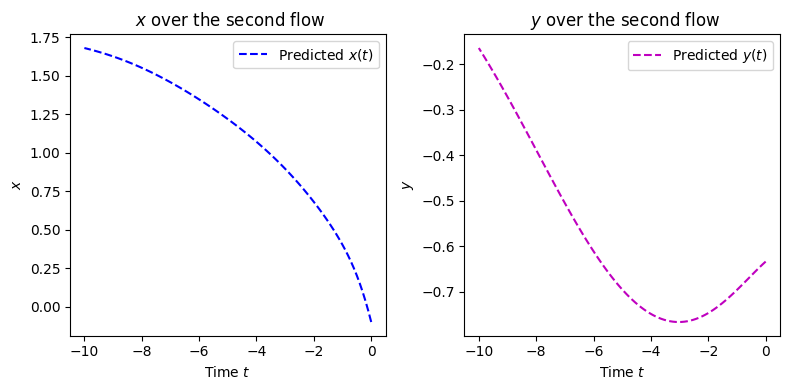

In [32]:
if __name__=='__main__':

    model_fast  = fast_system_PINN().to(torch.float64)  
    model_fast2 = fast_system_PINN2().to(torch.float64) 

    optimizer = torch.optim.Adam(list(model_fast.parameters()) + list(model_fast2.parameters()), lr=1e-3)
    loss_values = []
    epoch_num = 5000

    xf_end, yf_end =  np.random.uniform(1, 3), np.random.uniform(0, 2) #-2, -2 #
    xf2_end, yf2_end =  np.random.uniform(1, 2) , np.random.uniform(-1, 0) #-1, 2 #

    for epoch in range(epoch_num):
        optimizer.zero_grad()
        loss_total = total_loss_func(model_fast, model_fast2, t_tensor, t2_tensor,\
                                     x_init, y_init, xf_end, yf_end,\
                                     x_end, y_end, xf2_end, yf2_end, eps,\
                                     weight_fast=1.0)
        loss_total.backward()#(retain_graph=True)
        optimizer.step()
        with torch.no_grad():
            x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
            x_pred_fast2, y_pred_fast2 = model_fast2(t2_tensor).numpy().T

            xf_end,  yf_end  =  x_pred_fast2[-1], y_pred_fast2[-1]
            xf2_end, yf2_end = x_pred_fast[-1], y_pred_fast[-1]

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Total Loss: {loss_total.item()}')         
        loss_values.append(loss_total.item())
        
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.plot(range(0, epoch_num, 1000), np.log(loss_values[:epoch_num//1000]), 'b', label='Fast System')
    plt.xlabel('Epoch')
    plt.ylabel('Log(Loss)')
    plt.title('Training Loss Over Epochs (Fast System)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Model evaluation
    model_fast.eval()
    model_fast2.eval()
    with torch.no_grad():
        # Predictions for fast system
        x_pred_fast, y_pred_fast = model_fast(t_tensor).numpy().T
        # Predictions for fast2 system
        x_pred_fast2, y_pred_fast2 = model_fast2(t2_tensor).numpy().T
        
    # Plotting in 2D
    plt.figure(figsize=(12, 6))

    # Plot initial point
    plt.plot(x_real, y_real, 'b-', label='x')
    plt.plot(x_init, y_init, 'go', color='cyan', label='Initial point')
    # Plot numerical (fast)
    plt.plot(x_pred_fast, y_pred_fast, 'r--', label='Numerical (Fast)')

    # Plot ending point
    plt.plot(x_end, y_end, 'go', label='Ending point')
    # Plot numerical (fast 2)
    plt.plot(x_pred_fast2, y_pred_fast2, 'g--', label='Numerical (Fast)', alpha=0.5)

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Combined Fast and Slow Systems')
    plt.legend()
    #plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    #plt.plot(t, x_exact_fast, 'b-', label='Exact $x(t)$')
    plt.plot(x_pred_fast, y_pred_fast, 'b--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(' $x$ vs $y$ (1st piece)')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(x_pred_fast2, y_pred_fast2, 'm--', label='Predicted $x$ vs $y$')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title(' $x$ vs $y$ (2nd piece)')
    plt.legend()
    

    plt.tight_layout()
    plt.show()
    
    
     #########1st piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    #plt.plot(t, x_exact_fast, 'b-', label='Exact $x(t)$')
    plt.plot(t, x_pred_fast, 'b--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the first fast flow')
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(t, y_exact_fast, 'b-', label='Exact $y(t)$')
    plt.plot(t, y_pred_fast, 'm--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the first fast flow')
    plt.legend()
    

    plt.tight_layout()
    plt.show()
    
    
    
    ########2nd piece
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    #plt.plot(t2, x_exact_fast2 , 'b-', label='Exact $x(t)$')
    plt.plot(t2, x_pred_fast2 , 'b--', label='Predicted $x(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$x$')
    plt.title(' $x$ over the second flow')
    plt.legend()

    plt.subplot(1, 2, 2)
    #plt.plot(t2, y_exact_fast2 , 'b-', label='Exact $y(t)$')
    plt.plot(t2, y_pred_fast2 , 'm--', label='Predicted $y(t)$')
    plt.xlabel('Time $t$')
    plt.ylabel('$y$')
    plt.title(' $y$ over the second flow')
    plt.legend()
    

    plt.tight_layout()
    plt.show()


